CODE BLOCK: 1

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from utils import *
from model import *

CODE BLOCK: 2

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

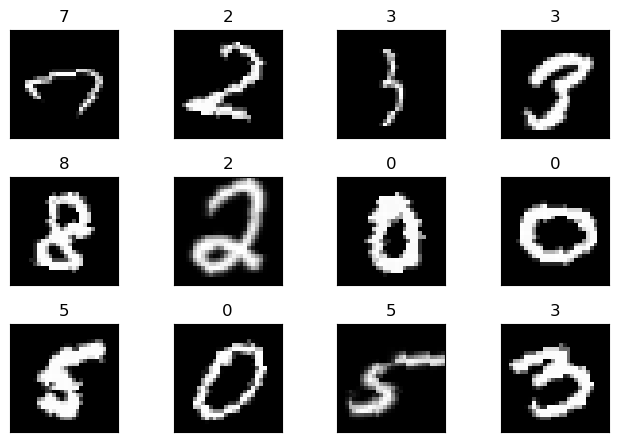

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [10]:
use_mps = torch.backends.mps.is_available()
device = torch.device("mps:0" if use_mps else "cpu")
model = Net().to(device)
model_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 10

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, nn.CrossEntropyLoss(reduction='sum'))
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.4515 Batch_id=117 Accuracy=43.20: 100%|██████████| 118/118 [00:13<00:00,  8.49it/s]


Test set: Average loss: 0.3652, Accuracy: 8766/10000 (87.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0860 Batch_id=117 Accuracy=91.95: 100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Test set: Average loss: 0.0988, Accuracy: 9691/10000 (96.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0802 Batch_id=117 Accuracy=95.88: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Test set: Average loss: 0.0731, Accuracy: 9758/10000 (97.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1440 Batch_id=117 Accuracy=96.69: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]


Test set: Average loss: 0.0534, Accuracy: 9837/10000 (98.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0358 Batch_id=117 Accuracy=97.29: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]


Test set: Average loss: 0.0486, Accuracy: 9841/10000 (98.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0784 Batch_id=117 Accuracy=97.71: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Test set: Average loss: 0.0424, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0508 Batch_id=117 Accuracy=97.79: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0181 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Test set: Average loss: 0.0338, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0836 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]


Test set: Average loss: 0.0295, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1129 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:12<00:00,  9.20it/s]


Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0174 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:12<00:00,  9.21it/s]


Test set: Average loss: 0.0326, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0160 Batch_id=117 Accuracy=98.56: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Test set: Average loss: 0.0304, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0432 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]


Test set: Average loss: 0.0232, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0579 Batch_id=117 Accuracy=98.74: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0149 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]


Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.1290 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.1096 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0692 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0116 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0152 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.


AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

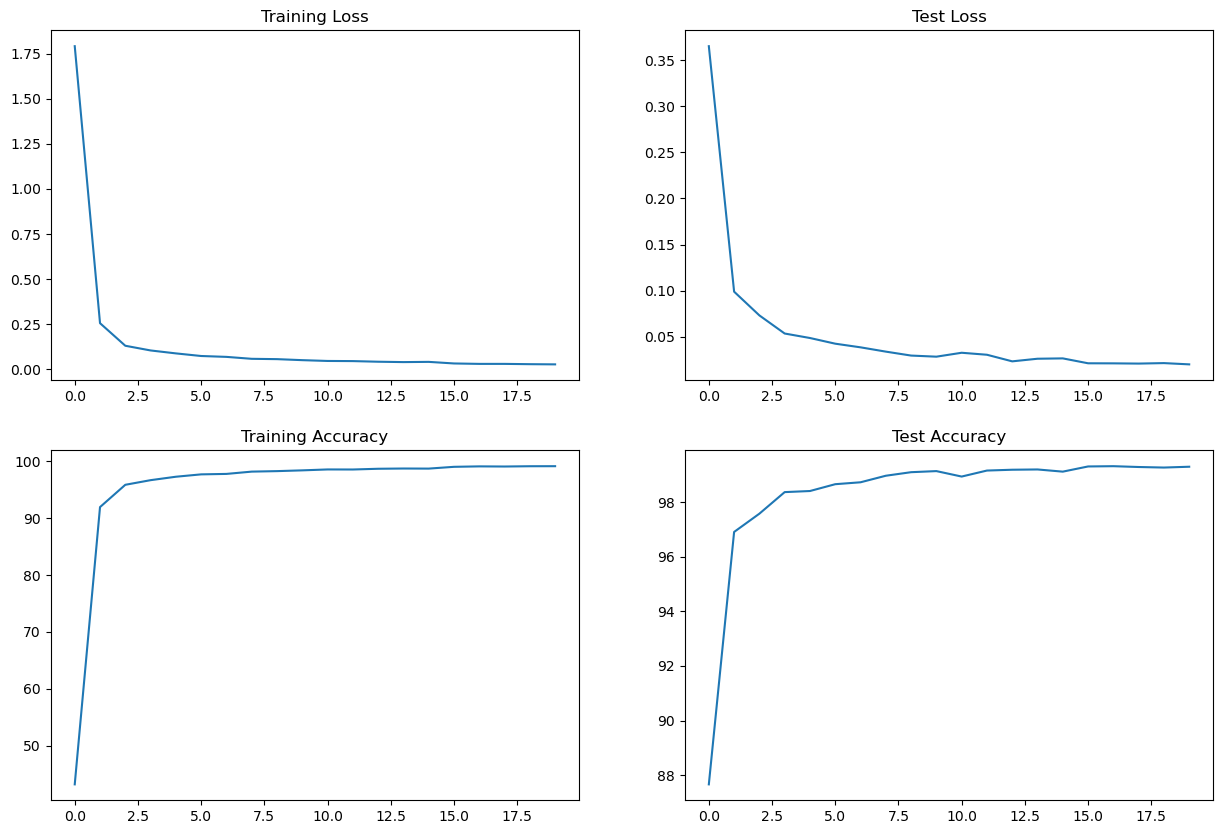

In [20]:
plt_fig(train_losses,train_acc,test_losses,test_acc)